In [2]:
stoi = {s:i for i, s in enumerate('.abcdefghijklmnopqrstuvwxyz')}
itos = {i: s for s, i in stoi.items()}


In [241]:
# Building Dataset
import torch
import torch.nn.functional as F
block_size = 3

with open('names.txt', 'r') as f:
    words = f.readlines()

X = []
Y = []

for word in words:
    context = [0] * block_size
    word = word.replace('\n', '')
    for char in word + '.':
        X.append(context)
        Y.append(stoi[char])
        # print(''.join([itos[i] for i in context]), '---->', itos[Y[-1]])
        context = context[1:] + [stoi[char]]
        

X = torch.tensor(X)        
Y = torch.tensor(Y)    
    

In [243]:
seed = 12345

n_embeds = 10
n_hidden = 200
vocab_size = 27

g = torch.Generator().manual_seed(seed)
C = torch.randn((27, n_embeds), generator=g, requires_grad=True)
embed = C[X]
W1 = torch.randn((n_embeds * block_size, n_hidden), generator=g, requires_grad=True)
b1 = torch.randn(n_hidden, generator=g, requires_grad=True)
W2 = torch.randn((n_hidden, vocab_size), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)

parameters = [C, W1, b1, W2, b2]

In [244]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [245]:
lri = []
lossi = []
for i in range(1000):
    # minibatch
    ix = torch.randint(0, X.shape[0], (32,))
    
    embs = C[X[ix]]
    h = torch.tanh(embs.view(-1, n_embeds * block_size) @ W1 + b1)
    logits = h @ W2 + b2
    # counts = logits.exp()
    # probs = counts / counts.sum(1, keepdim=True)
    # loss = -probs[torch.arange(embs.shape[0]), Y].log().mean()
    loss = F.cross_entropy(logits, Y[ix])
    
    for p in parameters:
        p.grad = None

    loss.backward()
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())
    
embs = C[X]
h = torch.tanh(embs.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
# counts = logits.exp()
# probs = counts / counts.sum(1, keepdim=True)
# loss = -probs[torch.arange(embs.shape[0]), Y].log().mean()
loss = F.cross_entropy(logits, Y)
print(loss.item())

13.682428359985352


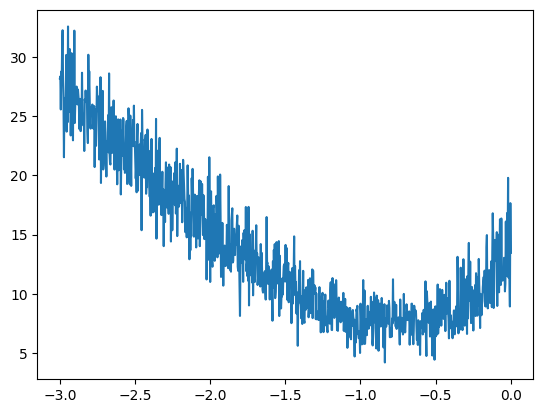

In [246]:
import matplotlib.pyplot as plt

plt.plot(lri, lossi)

# select lr from this plot

In [250]:
from tqdm import tqdm

lossi = []
stepsi = []

def build_dataset(words):
    X = []
    Y = []
    for word in words:
        context = [0] * block_size
        word = word.replace('\n', '')
        for char in word + '.':
            X.append(context)
            Y.append(stoi[char])
            # print(''.join([itos[i] for i in context]), '---->', itos[Y[-1]])
            context = context[1:] + [stoi[char]]
    X = torch.tensor(X)        
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

def train(Xtr, Ytr, batch_size=32, steps=10000, lr=0.1):
    lr_switch = steps//2
    for i in tqdm(range(steps)):
        # minibatch
        ix = torch.randint(0, Xtr.shape[0], (batch_size,))
        
        embs = C[Xtr[ix]]
        h = torch.tanh(embs.view(-1, n_embeds * block_size) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Ytr[ix])
        
        for p in parameters:
            p.grad = None

        loss.backward()
        if i == lr_switch:
            lr = lr/10
        for p in parameters:
            p.data += -lr * p.grad
            
        # track stats
        stepsi.append(i)
        lossi.append(loss.item())
    plt.plot(stepsi, lossi)
    plt.show()     
    return

@torch.no_grad()
def test(Xte, Yte):
            
    embs = C[Xte]
    h = torch.tanh(embs.view(-1, n_embeds * block_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yte)
    
    for p in parameters:
        p.grad = None
    
    print(f"Loss: {loss.item()}")
    return
   

In [248]:
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr= build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


100%|██████████| 200000/200000 [01:41<00:00, 1979.81it/s]


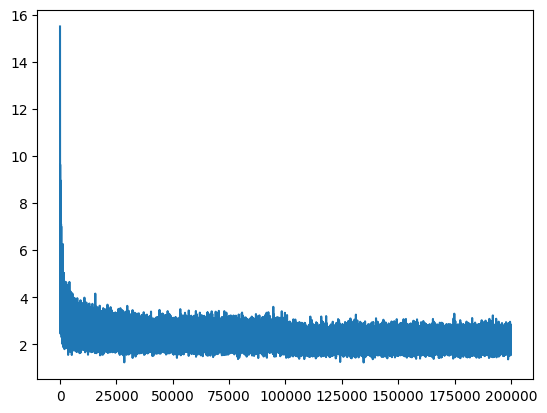

Loss: 2.171877145767212
Loss: 2.11287260055542


In [249]:
train(Xtr, Ytr, batch_size=32, steps=200_000, lr=0.1)
test(Xdev, Ydev)
test(Xtr, Ytr)

In [232]:
test(Xte, Yte)

Loss: 2.1881918907165527


In [255]:
def generate_name(start_chars='...', num_names=10):
    out = []
    for _ in range(num_names):
        name = start_chars
        row = name[-3:]
        
        while True:
            context = torch.tensor([stoi[char] for char in row])
            e = C[context]
            h = torch.tanh(e.view(-1, 30) @ W1 + b1)
            logits = h @ W2 + b2
            counts = logits.exp()
            probs = counts/ counts.sum(dim=1, keepdim=True)
            char = itos[torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()]
            name += char
            if char == '.':
                break
            row = name[-3:]
        out.append(name)
    return out

out = generate_name()
out      

['...amin.',
 '...yarajeison.',
 '...ola.',
 '...jerra.',
 '...meh.',
 '...sca.',
 '...micha.',
 '...mafel.',
 '...ezmi.',
 '...mawf.']